Read Combined Dataset that we built for Zillow based on Exploratory Analysis result with Values for each Year on  Combination of State and County Name for each of AllHomes, 3 Bed Room, 2 Bed Room, Condo , Percapita Income, Population Growth 

This dataset is input from Exploratory Analysis Result. Models that we build are Random Forest, XGBoost, LASSO, LGBM , SVR . All these models are categorised as Machine Learning Models for Time Series as we work for regression as Housing Dataset has non linear features. 

In [34]:
import xgboost as xgb
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
dirpath = os.path.join(os.getcwd(), "DS_2025_TeamE\data_files")
# Check if directory exists
if not os.path.exists(dirpath):
    raise FileNotFoundError(f"The directory {dirpath} does not exist.")
else:
    print(f"The directory {dirpath} exists.")
    # List all files in the directory
files_in_dir = os.listdir(dirpath)
print(dirpath)
zhvi_filename = 'zillow_combined_zhvi.csv'
zhvi_filepath = os.path.join(dirpath, zhvi_filename)
zhvi_condo_df = pd.read_csv(zhvi_filepath, header=None)  # Read without headers
zhvi_condo_df.columns = zhvi_condo_df.iloc[0]  # Set first row as column names
zhvi_condo_df = zhvi_condo_df[1:].reset_index(drop=True)  # Remove first row from data
zhvi_condo_fmt_df = zhvi_condo_df.copy()


The directory c:\Users\req92163\OneDrive - Mutual of Omaha\DSCI8950\DS_2025_TeamE\data_files exists.
c:\Users\req92163\OneDrive - Mutual of Omaha\DSCI8950\DS_2025_TeamE\data_files


Convert Decimal Values to Integer. Replace Nulls with 0s

In [35]:
# Ensure 'Personal_Income_Growth' is of numeric type before imputation
zhvi_condo_fmt_df['Personal_Income_Growth'] = pd.to_numeric(zhvi_condo_fmt_df['Personal_Income_Growth'], errors='coerce')
zhvi_condo_fmt_df['Population_Growth'] = pd.to_numeric(zhvi_condo_fmt_df['Population_Growth'], errors='coerce')
zhvi_condo_fmt_df['Per_Capita_Income_Growth'] = pd.to_numeric(zhvi_condo_fmt_df['Per_Capita_Income_Growth'], errors='coerce')
numeric_cols = zhvi_condo_fmt_df.select_dtypes(include=[np.number]).columns
zhvi_condo_fmt_df[numeric_cols] = zhvi_condo_fmt_df[numeric_cols].fillna(0)
zhvi_condo_fmt_df['Previous_AnnualValue_AllHomes'] = zhvi_condo_fmt_df['Previous_AnnualValue_AllHomes'].replace(0, np.nan)
zhvi_condo_fmt_df = zhvi_condo_fmt_df[['County', 'State', 'Year_Recorded', 
                                       'Personal_Income_Growth', 'Population_Growth', 'Per_Capita_Income_Growth',
                                       'AnnualValue_AllHomes', 'Previous_AnnualValue_AllHomes', 'Annual_Increase_AllHomes',
                                       'AnnualValue_SingleFamily', 'Previous_AnnualValue_SingleFamily','Annual_Increase_SingleFamily',
                                       'AnnualValue_Condo', 'Previous_AnnualValue_Condo', 'Annual_Increase_Condo',
                                       'AnnualValue_ThreeBedRoom', 'Previous_AnnualValue_ThreeBedRoom', 'Annual_Increase_ThreeBedRoom',
                                       'AnnualValue_TwoBedRoom', 'Previous_AnnualValue_TwoBedRoom', 'Annual_Increase_TwoBedRoom']]
# Convert all object columns to numeric except 'County' and 'State'
columns_to_convert = zhvi_condo_fmt_df.select_dtypes(include=['object']).columns.difference(['County', 'State'])
zhvi_condo_fmt_df[columns_to_convert] = zhvi_condo_fmt_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
zhvi_condo_fmt_df[numeric_cols] = zhvi_condo_fmt_df[numeric_cols].fillna(0)
zhvi_condo_fmt_df[zhvi_condo_fmt_df.select_dtypes(include=['float64']).columns] = zhvi_condo_fmt_df.select_dtypes(include=['float64']).fillna(0)
# Convert specific columns to nearest integer
zhvi_condo_fmt_df['Personal_Income_Growth'] = zhvi_condo_fmt_df['Personal_Income_Growth'].round(0).astype(int)
zhvi_condo_fmt_df['Population_Growth'] = zhvi_condo_fmt_df['Population_Growth'].round(0).astype(int)
zhvi_condo_fmt_df['Per_Capita_Income_Growth'] = zhvi_condo_fmt_df['Per_Capita_Income_Growth'].round(0).astype(int)
zhvi_condo_fmt_df['Annual_Increase_AllHomes'] = zhvi_condo_fmt_df['Annual_Increase_AllHomes'].round(0).astype(int)

# Convert all remaining float columns to nearest 100
float_cols = zhvi_condo_fmt_df.select_dtypes(include=['float64']).columns.difference(['Personal_Income_Growth', 'Population_Growth', 'Per_Capita_Income_Growth', 'Annual_Increase_AllHomes'])
zhvi_condo_fmt_df[float_cols] = zhvi_condo_fmt_df[float_cols].apply(lambda x: (x / 100).round(0) * 100)
float_cols = zhvi_condo_fmt_df.select_dtypes(include=['float64']).columns
zhvi_condo_fmt_df[float_cols] = zhvi_condo_fmt_df[float_cols].astype(int)
zhvi_condo_fmt_df.isnull().sum()

0
County                               0
State                                0
Year_Recorded                        0
Personal_Income_Growth               0
Population_Growth                    0
Per_Capita_Income_Growth             0
AnnualValue_AllHomes                 0
Previous_AnnualValue_AllHomes        0
Annual_Increase_AllHomes             0
AnnualValue_SingleFamily             0
Previous_AnnualValue_SingleFamily    0
Annual_Increase_SingleFamily         0
AnnualValue_Condo                    0
Previous_AnnualValue_Condo           0
Annual_Increase_Condo                0
AnnualValue_ThreeBedRoom             0
Previous_AnnualValue_ThreeBedRoom    0
Annual_Increase_ThreeBedRoom         0
AnnualValue_TwoBedRoom               0
Previous_AnnualValue_TwoBedRoom      0
Annual_Increase_TwoBedRoom           0
dtype: int64

Build Train and Test Datasets Train Data is taken from 2019 to 2023. . Test Data will be taken as 2024 data as it has accurate actual values to predict for test.

In [36]:
def prepare_train_test_data(target_column):
    if target_column == 'AnnualValue_AllHomes':
        features = ['County', 'State', 'Personal_Income_Growth', 'Population_Growth', 'Per_Capita_Income_Growth',
                    'Annual_Increase_AllHomes', 'Previous_AnnualValue_AllHomes']
    elif target_column == 'AnnualValue_SingleFamily':
        features = ['County', 'State', 'Personal_Income_Growth', 'Population_Growth', 'Per_Capita_Income_Growth',
                    'Annual_Increase_SingleFamily', 'Previous_AnnualValue_SingleFamily']
    elif target_column == 'AnnualValue_Condo':
        features = ['County', 'State', 'Personal_Income_Growth', 'Population_Growth', 'Per_Capita_Income_Growth',
                    'Annual_Increase_Condo', 'Previous_AnnualValue_Condo']
    elif target_column == 'AnnualValue_ThreeBedRoom':
        features = ['County', 'State', 'Personal_Income_Growth', 'Population_Growth', 'Per_Capita_Income_Growth',
                    'Annual_Increase_ThreeBedRoom', 'Previous_AnnualValue_ThreeBedRoom']
    elif target_column == 'AnnualValue_TwoBedRoom':
        features = ['County', 'State', 'Personal_Income_Growth', 'Population_Growth', 'Per_Capita_Income_Growth',
                    'Annual_Increase_TwoBedRoom', 'Previous_AnnualValue_TwoBedRoom']

    # Filter the data for training (years 2020 to 2023)
    train_df = zhvi_condo_fmt_df[(zhvi_condo_fmt_df['Year_Recorded'] < 2024) & (zhvi_condo_fmt_df[target_column] != 0)][features + [target_column, 'Year_Recorded']]
    train_df = train_df.dropna(subset=[target_column])  # Drop rows with NaN in the target column

    # Create a test dataframe for prediction (year 2024)
    test_df = zhvi_condo_fmt_df[(zhvi_condo_fmt_df['Year_Recorded'] == 2024) & (zhvi_condo_fmt_df[target_column] != 0)][features + [target_column, 'Year_Recorded']].copy()
    test_df['Year_Recorded'] = 2025

    X_train, y_train = train_df[features], train_df[target_column]
    X_test, y_test = test_df[features], test_df[target_column]

    # Convert categorical features to numeric using one-hot encoding
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    return X_train, X_test, y_train, y_test, test_df

X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, test_df_allhomes = prepare_train_test_data('AnnualValue_AllHomes')
X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, test_df_singlefamily = prepare_train_test_data('AnnualValue_SingleFamily')
X_train_condo, X_test_condo, y_train_condo, y_test_condo, test_df_condo = prepare_train_test_data('AnnualValue_Condo')
X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, test_df_twobedroom = prepare_train_test_data('AnnualValue_TwoBedRoom')
X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, test_df_threebedroom = prepare_train_test_data('AnnualValue_ThreeBedRoom')

Build Process to evaluate model result metrics for All Homes , Condo, Single Family, 2 Bed Room, 3 Bed Room .

In [37]:
def evaluate_regression_model(model, X_train, X_test, y_train, y_test, category):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_rmse = round(np.sqrt(mean_squared_error(y_train, y_pred_train)), -2)
    test_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred_test)), -2)
    
    train_mae = round(mean_absolute_error(y_train, y_pred_train), -2)
    test_mae = round(mean_absolute_error(y_test, y_pred_test), -2)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    #print(f"{category} Train RMSE: {train_rmse:.4f}")
    #print(f"{category} Test RMSE: {test_rmse:.4f}")
    #print(f"{category} Train MAE: {train_mae:.4f}")
    #print(f"{category} Test MAE: {test_mae:.4f}")
    #print(f"{category} Train R2: {train_r2:.4f}")
    #print(f"{category} Test R2: {test_r2:.4f}")
    #print(f"{category} Train Accuracy: {train_accuracy:.2f}%")
    #print(f"{category} Test Accuracy: {test_accuracy:.2f}%")
    results_df = pd.DataFrame({
        'Category': [category],
        'Train RMSE': [int(train_rmse)],
        'Test RMSE': [int(test_rmse)],
        'Train MAE': [int(train_mae)],
        'Test MAE': [int(test_mae)],
        'Train R2': [round(train_r2, 2)],
        'Test R2': [round(test_r2, 2)]
    })
    
    return results_df

 





Build Random Forest Model . Use Random Forest Grid CV to build Model using Train/Test Data.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import warnings
import logging
def train_and_predict_rf_model(target_column, X_train, X_test, y_train, y_test, test_df):
    # Initialize the RandomForestRegressor
    rf_model = RandomForestRegressor(random_state=42)
    # Perform GridSearchCV with reduced parameter grid for faster execution
    param_grid = {
        'n_estimators': [50, 100],  # Reduced number of trees
        'max_depth': [None, 6],  # Fewer depth options
        'min_samples_split': [2],  # Fixed minimum samples to split
        'min_samples_leaf': [1],  # Fixed minimum samples at leaf
        'max_features': ['sqrt'],  # Single option for max features
        'bootstrap': [True]  # Keep bootstrap enabled
    }
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV (already trained on the full training data used in CV)
    rf_model = grid_search.best_estimator_
    print(f"Best parameters for {target_column}: {grid_search.best_params_}")

    # Evaluate the best model using cross-validation scores (from GridSearchCV)
    cv_scores = -grid_search.cv_results_['mean_test_score']  # Get mean test scores (neg_MSE)
    rmse_cv = np.sqrt(cv_scores)
    print(f"Cross-Validation RMSE for {target_column}: {int(round(rmse_cv.mean(), -2))} (± {int(round(rmse_cv.std(), -2))})")

    # Prediction on test set using the best model
    y_pred = rf_model.predict(X_test)
    rmse = int(np.ceil(np.sqrt(mean_squared_error(y_test, y_pred)) / 100) * 100)
    mae = int(np.ceil(mean_absolute_error(y_test, y_pred)) / 100) * 100
    y_pred_rounded = (np.ceil(y_pred / 100) * 100).astype(int)
    print(f"RMSE on test set for {target_column}: {rmse}")
    print(f"MAE on test set for {target_column}: {mae}")

    predictions_df = test_df.copy()
    predictions_df['Predicted_Value'] = y_pred_rounded

    return rf_model, predictions_df

# Example usage
rf_model_allhomes, predictions_rf_allhomes = train_and_predict_rf_model('AnnualValue_AllHomes', X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, test_df_allhomes)
rf_model_condo, predictions_rf_condo = train_and_predict_rf_model('AnnualValue_Condo', X_train_condo, X_test_condo, y_train_condo, y_test_condo, test_df_condo)
rf_model_singlefamily, predictions_rf_singlefamily = train_and_predict_rf_model('AnnualValue_SingleFamily', X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, test_df_singlefamily)
rf_model_twobedroom, predictions_rf_twobedroom = train_and_predict_rf_model('AnnualValue_TwoBedRoom', X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, test_df_twobedroom)
rf_model_threebedroom, predictions_rf_threebedroom = train_and_predict_rf_model('AnnualValue_ThreeBedRoom', X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, test_df_threebedroom)

Best parameters for AnnualValue_AllHomes: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Cross-Validation RMSE for AnnualValue_AllHomes: 123000 (± 36800)
RMSE on test set for AnnualValue_AllHomes: 53700
MAE on test set for AnnualValue_AllHomes: 20100
Best parameters for AnnualValue_Condo: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Cross-Validation RMSE for AnnualValue_Condo: 97300 (± 33500)
RMSE on test set for AnnualValue_Condo: 39400
MAE on test set for AnnualValue_Condo: 19200
Best parameters for AnnualValue_SingleFamily: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Cross-Validation RMSE for AnnualValue_SingleFamily: 175600 (± 34200)
RMSE on test set for AnnualValue_SingleFamily: 73500
MAE on test set for AnnualValue_SingleFamily:

Build the Test RMSE and Train RMSE 

In [39]:
results_allhomes = evaluate_regression_model(
    rf_model_allhomes, X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, 'AllHomes')

# Evaluate the model for 'AnnualValue_Condo'
results_condo = evaluate_regression_model(
    rf_model_condo, X_train_condo, X_test_condo, y_train_condo, y_test_condo, 'Condo')

# Evaluate the model for 'AnnualValue_SingleFamily'
results_singlefamily = evaluate_regression_model(
    rf_model_singlefamily, X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, 'SingleFamily')

# Evaluate the model for 'AnnualValue_ThreeBedRoom'
results_threebedroom = evaluate_regression_model(
    rf_model_threebedroom, X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, 'ThreeBedRoom')

# Evaluate the model for 'AnnualValue_TwoBedRoom'
results_twobedroom = evaluate_regression_model(
    rf_model_twobedroom, X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, 'TwoBedRoom')

# Merge all results into one dataframe
rf_results_df = pd.concat([results_allhomes, results_condo, results_singlefamily, results_threebedroom, results_twobedroom], ignore_index=True)
rf_results_df

,Category,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
0,AllHomes,17400,53600,6500,20200,0.99,0.92
1,Condo,14100,39300,8600,19300,0.99,0.93
2,SingleFamily,21700,73500,7200,19700,0.99,0.92
3,ThreeBedRoom,17700,53000,7400,19400,0.99,0.93
4,TwoBedRoom,12700,32000,5900,14800,0.99,0.95


Build Predictions on Test Dataset

In [40]:
predictions_rf_allhomes[predictions_rf_allhomes['Predicted_Value'].notnull()][['County', 'State', 'AnnualValue_AllHomes', 'Predicted_Value']].head(10)


,County,State,AnnualValue_AllHomes,Predicted_Value
4,AUTAUGA,AL,202500,199200
9,BALDWIN,AL,349500,349700
14,BARBOUR,AL,145800,154900
19,BIBB,AL,198500,195100
24,BLOUNT,AL,229300,219300
29,BULLOCK,AL,98200,129700
34,CALHOUN,AL,172200,183300
39,CHAMBERS,AL,167500,174600
44,CHILTON,AL,219500,219900
49,CLAY,AL,136700,145200


Build XGB Model .We need to predict prices for different categories i.e.  AllHomes, Single Family, Condo, Two Bedroom, Three Bedroom. 
So will take features i.e. personal Income Growth , Population Growth , Per Capita Income, Annual Increase Percent(for category), Previous Annual Value(for Category) 
Build Function that builds XGB Model for each category i.e. target_column. Perform Predictions on test dataset and write to dataframe.Return Model, Train , Test Features/Target columns along with Prediction results for each of category.

We are running models to predict values for AllHomes, SingleFamily, Condo, TwoBedRoom, ThreeBedRoom one after another.  

XGBOOST is highly popular and effective machine learning algorithm , particularly for regression tasks like house prediction .It handles non-linear relationships, Overfitting of data. It is more scalable and can handle null values. It produces highly predictive accurate results.

Implement Crossfold 5 Fold validation.

In [41]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Suppress warnings and logging messages that contain "cmdstanpy"
warnings.filterwarnings("ignore", message=".*cmdstanpy.*")
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)
import warnings
import warnings
import logging
# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress all errors (optional, but not recommended for debugging)
import sys
sys.tracebacklimit = 0
def train_and_predict_xgb_model(target_column, X_train, X_test, y_train, y_test, test_df):
    # Initialize the XGBoost Regressor
    xgb_model = XGBRegressor(random_state=42)

    # Define the parameter grid for GridSearchCV

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [50, 100],  # Number of trees
        'max_depth': [3, 6],  # Maximum depth of the tree
        'learning_rate': [0.01, 0.1],  # Learning rate
        'subsample': [0.8],  # Subsample ratio of the training instances
        'colsample_bytree': [0.8],  # Subsample ratio of columns when constructing each tree
        'gamma': [0]  # Minimum loss reduction required to make a further partition
    }


    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    xgb_model = grid_search.best_estimator_
    print(f"Best parameters for {target_column}: {grid_search.best_params_}")

    # Evaluate the best model using cross-validation scores (from GridSearchCV)
    cv_scores = -grid_search.cv_results_['mean_test_score']  # Get mean test scores (neg_MSE)
    rmse_cv = np.sqrt(cv_scores)
    print(f"Cross-Validation RMSE for {target_column}: {int(round(rmse_cv.mean(), -2))} (± {int(round(rmse_cv.std(), -2))})")

    # Prediction on test set using the best model
    y_pred = xgb_model.predict(X_test)
    rmse = int(np.ceil(np.sqrt(mean_squared_error(y_test, y_pred)) / 100) * 100)
    mae = int(np.ceil(mean_absolute_error(y_test, y_pred)) / 100) * 100
    y_pred_rounded = (np.ceil(y_pred / 100) * 100).astype(int)
    print(f"RMSE on test set for {target_column}: {rmse}")
    print(f"MAE on test set for {target_column}: {mae}")

    predictions_df = test_df.copy()
    predictions_df['Predicted_Value'] = y_pred_rounded

    return xgb_model, predictions_df

# Example usage
xgb_model_allhomes, predictions_xgb_allhomes = train_and_predict_xgb_model('AnnualValue_AllHomes', X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, test_df_allhomes)
xgb_model_condo, predictions_xgb_condo = train_and_predict_xgb_model('AnnualValue_Condo', X_train_condo, X_test_condo, y_train_condo, y_test_condo, test_df_condo)
xgb_model_singlefamily, predictions_xgb_singlefamily = train_and_predict_xgb_model('AnnualValue_SingleFamily', X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, test_df_singlefamily)
xgb_model_twobedroom, predictions_xgb_twobedroom = train_and_predict_xgb_model('AnnualValue_TwoBedRoom', X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, test_df_twobedroom)
xgb_model_threebedroom, predictions_xgb_threebedroom = train_and_predict_xgb_model('AnnualValue_ThreeBedRoom', X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, test_df_threebedroom)

Best parameters for AnnualValue_AllHomes: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Cross-Validation RMSE for AnnualValue_AllHomes: 80300 (± 31200)
RMSE on test set for AnnualValue_AllHomes: 33100
MAE on test set for AnnualValue_AllHomes: 4400
Best parameters for AnnualValue_Condo: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Cross-Validation RMSE for AnnualValue_Condo: 60200 (± 32500)
RMSE on test set for AnnualValue_Condo: 24400
MAE on test set for AnnualValue_Condo: 16000
Best parameters for AnnualValue_SingleFamily: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Cross-Validation RMSE for AnnualValue_SingleFamily: 132700 (± 25900)
RMSE on test set for AnnualValue_SingleFamily: 43700
MAE on test set for AnnualValue_SingleFamily: 10000
Best parameters for AnnualValue_TwoBedRoom

Display few records with actual vs predicted values

In [42]:
predictions_xgb_allhomes[predictions_rf_allhomes['Predicted_Value'].notnull()][['County', 'State', 'AnnualValue_AllHomes', 'Predicted_Value']].head(10)


,County,State,AnnualValue_AllHomes,Predicted_Value
4,AUTAUGA,AL,202500,202500
9,BALDWIN,AL,349500,352600
14,BARBOUR,AL,145800,146500
19,BIBB,AL,198500,199300
24,BLOUNT,AL,229300,230600
29,BULLOCK,AL,98200,98700
34,CALHOUN,AL,172200,172300
39,CHAMBERS,AL,167500,167600
44,CHILTON,AL,219500,219300
49,CLAY,AL,136700,135200


Calculate XGB Model regression stats for each of category and write to dataframe . Create function and call for each of feature.
We are taking tolerance as 10% of actual vs predicted values for accuracy.

In [43]:

    # Evaluate the model for 'AnnualValue_AllHomes'
results_allhomes = evaluate_regression_model(
        xgb_model_allhomes, X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, 'AllHomes')

    # Evaluate the model for 'AnnualValue_Condo'
results_condo = evaluate_regression_model(
        xgb_model_condo, X_train_condo, X_test_condo, y_train_condo, y_test_condo, 'Condo')

    # Evaluate the model for 'AnnualValue_SingleFamily'
results_singlefamily = evaluate_regression_model(
        xgb_model_singlefamily, X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, 'SingleFamily')

    # Evaluate the model for 'AnnualValue_ThreeBedRoom'
results_threebedroom = evaluate_regression_model(
        xgb_model_threebedroom, X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, 'ThreeBedRoom')

    # Evaluate the model for 'AnnualValue_TwoBedRoom'
results_twobedroom = evaluate_regression_model(
        xgb_model_twobedroom, X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, 'TwoBedRoom')

    # Merge all results into one dataframe
xgb_results_df = pd.concat([results_allhomes, results_condo, results_singlefamily, results_threebedroom, results_twobedroom], ignore_index=True)
xgb_results_df







,Category,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
0,AllHomes,4400,33000,2100,4400,1.00,0.97
1,Condo,19000,24300,12600,16100,0.98,0.97
2,SingleFamily,20000,43700,8700,10000,0.99,0.97
3,ThreeBedRoom,19000,31200,10000,11600,0.99,0.97
4,TwoBedRoom,13600,17000,7800,9600,0.99,0.99


Build the feature Importance Plot . Exclude State and County as they are not required.

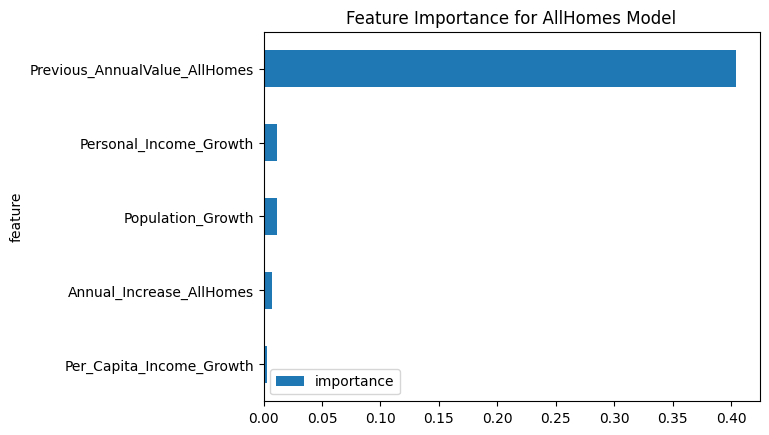

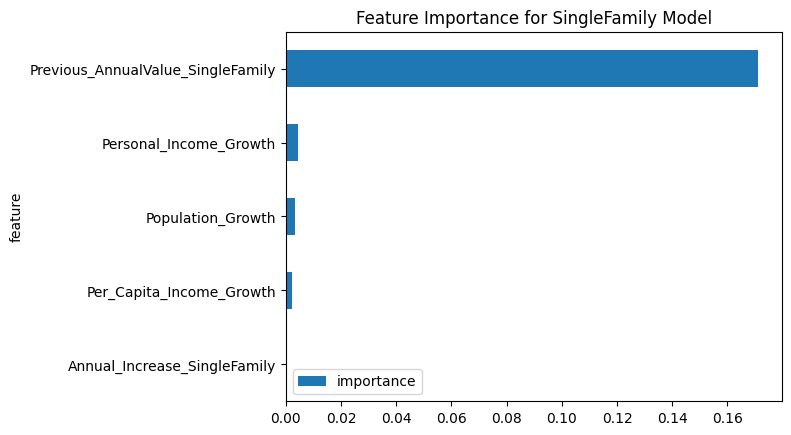

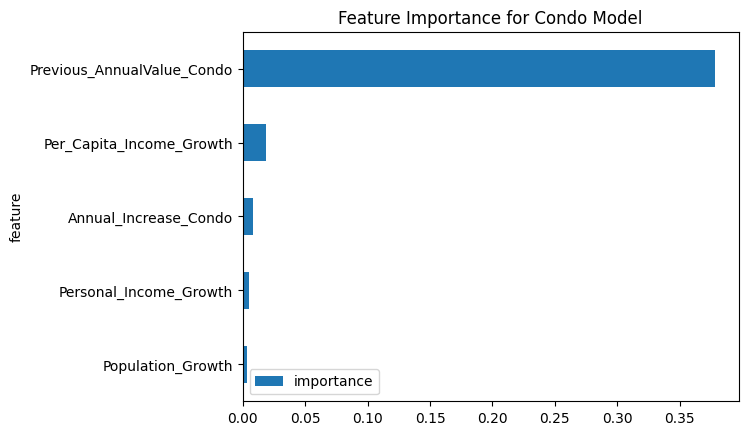

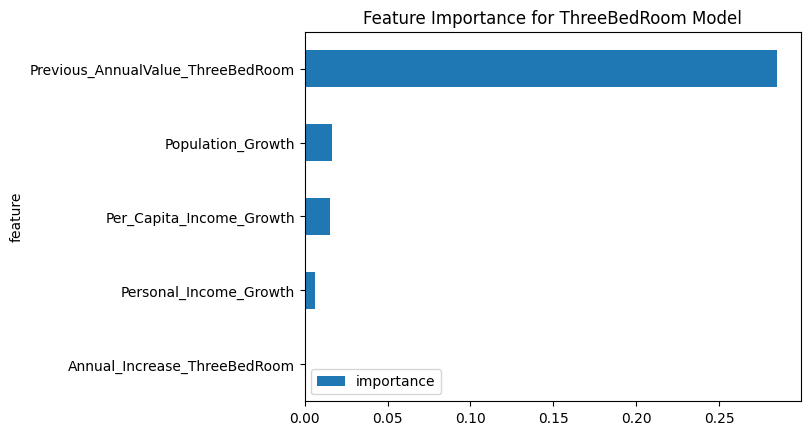

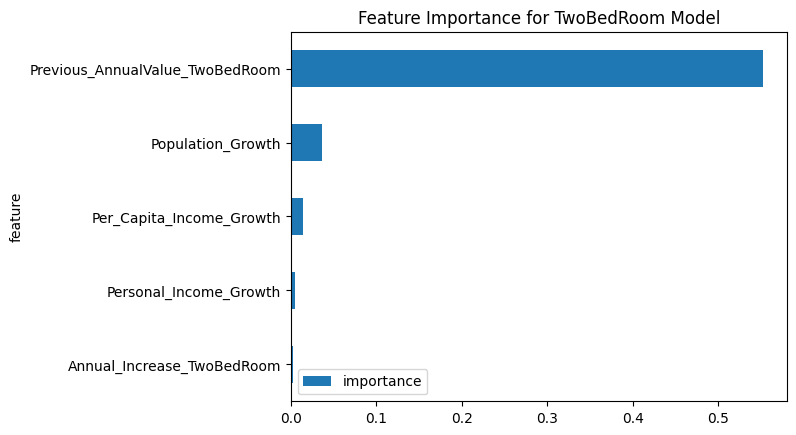

In [44]:
import matplotlib.pyplot as plt

#
def plot_feature_importance(model, columns_allhomes,title):
        feature_importance = model.feature_importances_
        fi = pd.DataFrame({'feature': columns_allhomes, 'importance': feature_importance})
        fi = fi.set_index('feature')
        fi_filtered = fi.drop(index=[col for col in fi.index if col.startswith('County') or col.startswith('State')])
        fi_filtered.sort_values('importance').plot(kind='barh', title=title)
        plt.show()

    # Plot feature importance for AllHomes model
plot_feature_importance(xgb_model_allhomes, X_train_allhomes.columns,'Feature Importance for AllHomes Model')
plot_feature_importance(xgb_model_singlefamily, X_train_singlefamily.columns,'Feature Importance for SingleFamily Model')
plot_feature_importance(xgb_model_condo, X_train_condo.columns,'Feature Importance for Condo Model')
plot_feature_importance(xgb_model_threebedroom, X_train_threebedroom.columns,'Feature Importance for ThreeBedRoom Model')
plot_feature_importance(xgb_model_twobedroom, X_train_twobedroom.columns,'Feature Importance for TwoBedRoom Model')

Build the Scattered Area Plot that shows how the price predictions alligned with 2020 to 2025 on Model Build . Increase/Decrease is consistent with prior years.

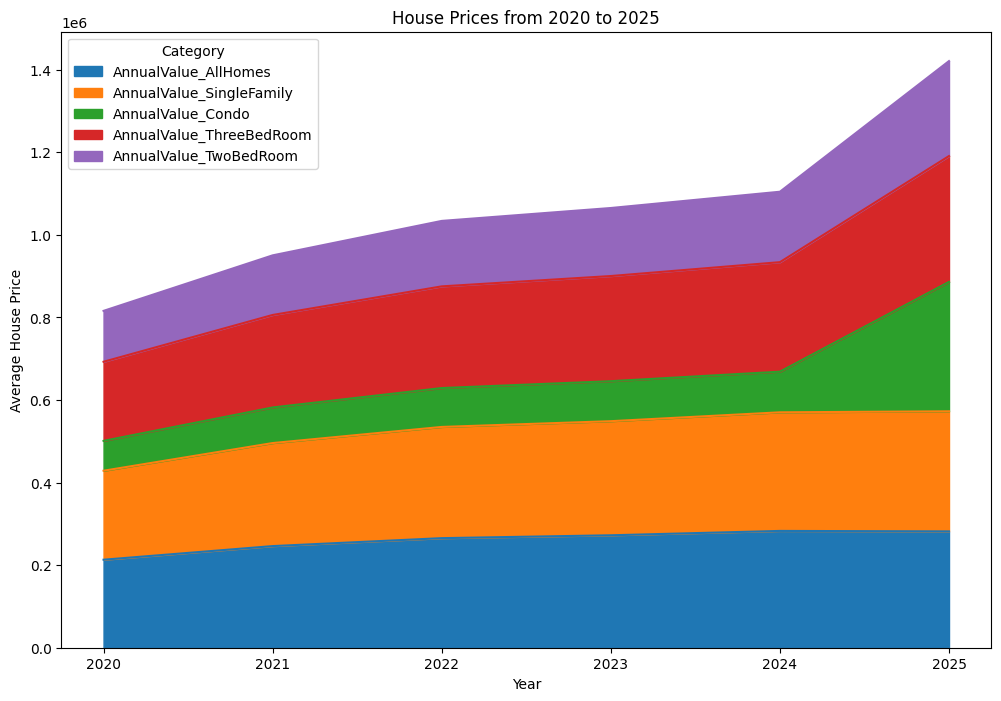

In [45]:
import matplotlib.pyplot as plt

# Filter the data for the years 2020 to 2025
years = [2020, 2021, 2022, 2023, 2024, 2025]
categories = ['AnnualValue_AllHomes', 'AnnualValue_SingleFamily', 'AnnualValue_Condo', 'AnnualValue_ThreeBedRoom', 'AnnualValue_TwoBedRoom']

# Create a new dataframe to hold the data for the plot
plot_data = pd.DataFrame(index=years, columns=categories)

# Populate the dataframe with the actual values for 2020 to 2024 and predicted values for 2025
for year in years:
    if year < 2025:
        year_data = zhvi_condo_fmt_df[zhvi_condo_fmt_df['Year_Recorded'] == year]
        for category in categories:
            plot_data.at[year, category] = year_data[category].mean()
    else:
        plot_data.at[year, 'AnnualValue_AllHomes'] = predictions_xgb_allhomes['Predicted_Value'].mean()
        plot_data.at[year, 'AnnualValue_SingleFamily'] = predictions_xgb_singlefamily['Predicted_Value'].mean()
        plot_data.at[year, 'AnnualValue_Condo'] = predictions_xgb_condo['Predicted_Value'].mean()
        plot_data.at[year, 'AnnualValue_ThreeBedRoom'] = predictions_xgb_threebedroom['Predicted_Value'].mean()
        plot_data.at[year, 'AnnualValue_TwoBedRoom'] = predictions_xgb_twobedroom['Predicted_Value'].mean()

# Convert the data to numeric type
plot_data = plot_data.astype(float)

# Plot the area plot
plot_data.plot(kind='area', stacked=True, figsize=(12, 8))
plt.title('House Prices from 2020 to 2025')
plt.xlabel('Year')
plt.ylabel('Average House Price')
plt.legend(title='Category')
plt.show()

Build XGBM Model with AR

In [46]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
# Suppress warnings and logging messages that contain "cmdstanpy"
warnings.filterwarnings("ignore", message=".*cmdstanpy.*")
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)
import warnings
import warnings
import logging

# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress all errors (optional, but not recommended for debugging)
import sys
sys.tracebacklimit = 0

def train_and_predict_xgb_ar_model(target_column, X_train, X_test, y_train, y_test, test_df):
    # Define the XGBoost Regressor
    xgb_model = xgb.XGBRegressor(random_state=42)

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [50, 100],  # Number of trees
        'max_depth': [3, 6],  # Maximum depth of the tree
        'learning_rate': [0.01, 0.1],  # Learning rate
        'subsample': [0.8],  # Subsample ratio of the training instances
        'colsample_bytree': [0.8],  # Subsample ratio of columns when constructing each tree
        'gamma': [0]  # Minimum loss reduction required to make a further partition
    }

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    best_xgb_model = grid_search.best_estimator_
    print(f"Best parameters for {target_column}: {grid_search.best_params_}")

    # Make predictions on train and test set
    y_train_pred = best_xgb_model.predict(X_train)
    y_test_pred = best_xgb_model.predict(X_test)

    # Calculate residuals (errors)
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    # Calculate errors before applying AR model
    rmse_before = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_before = mean_absolute_error(y_test, y_test_pred)

    

    # Fit AR model on the residuals of the train data
    ar_model = AutoReg(train_residuals, lags=1)  # Using 1 lag, can be tuned
    ar_model_fitted = ar_model.fit()

    # Predict the residuals on the test set using the AR model
    ar_predictions = ar_model_fitted.predict(start=len(train_residuals), end=len(train_residuals) + len(test_residuals) - 1, dynamic=False)

    # Correct the test predictions by adding AR residual predictions
    y_test_corrected = y_test_pred + ar_predictions

    # Evaluate the model on the corrected predictions
    rmse = int(np.ceil(np.sqrt(mean_squared_error(y_test, y_test_corrected)) / 100) * 100)  # Round RMSE to next 100
    mae = int(np.ceil(mean_absolute_error(y_test, y_test_corrected) / 100) * 100)  # Round MAE to next 100

    print(f"RMSE on test set after AR correction for {target_column}: {rmse}")
    print(f"MAE on test set after AR correction for {target_column}: {mae}")
    
    # Calculate errors after applying AR model
    rmse_after = np.sqrt(mean_squared_error(y_test, y_test_corrected))
    mae_after = mean_absolute_error(y_test, y_test_corrected)

    # Calculate reduction in errors
    rmse_reduction = rmse_before - rmse_after
    mae_reduction = mae_before - mae_after

    # Print the results
    print(f"RMSE Before AR Model: {rmse_before:.2f}")
    print(f"RMSE After AR Model: {rmse_after:.2f}")
    print(f"RMSE Reduction: {rmse_reduction:.2f}")

    print(f"MAE Before AR Model: {mae_before:.2f}")
    print(f"MAE After AR Model: {mae_after:.2f}")
    print(f"MAE Reduction: {mae_reduction:.2f}")

    predictions_df = test_df.copy()
    predictions_df['Predicted_Value'] = np.ceil(y_test_corrected / 100) * 100  # Round to nearest 100eil(y_test_corrected / 100) * 100  # Round to nearest 100
    return best_xgb_model, predictions_df

# Example usage
xgb_model_ar_allhomes, predictions_xgb_ar_allhomes = train_and_predict_xgb_ar_model('AnnualValue_AllHomes', X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, test_df_allhomes)
xgb_model_ar_condo, predictions_xgb_ar_condo = train_and_predict_xgb_ar_model('AnnualValue_Condo', X_train_condo, X_test_condo, y_train_condo, y_test_condo, test_df_condo)
xgb_model_ar_singlefamily, predictions_xgb_ar_singlefamily = train_and_predict_xgb_ar_model('AnnualValue_SingleFamily', X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, test_df_singlefamily)
xgb_model_ar_twobedroom, predictions_xgb_ar_twobedroom = train_and_predict_xgb_ar_model('AnnualValue_TwoBedRoom', X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, test_df_twobedroom)
xgb_model_ar_threebedroom, predictions_xgb_ar_threebedroom = train_and_predict_xgb_ar_model('AnnualValue_ThreeBedRoom', X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, test_df_threebedroom)


Best parameters for AnnualValue_AllHomes: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
RMSE on test set after AR correction for AnnualValue_AllHomes: 33100
MAE on test set after AR correction for AnnualValue_AllHomes: 4500
RMSE Before AR Model: 33048.20
RMSE After AR Model: 33048.09
RMSE Reduction: 0.11
MAE Before AR Model: 4437.30
MAE After AR Model: 4437.53
MAE Reduction: -0.23
Best parameters for AnnualValue_Condo: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
RMSE on test set after AR correction for AnnualValue_Condo: 24400
MAE on test set after AR correction for AnnualValue_Condo: 16100
RMSE Before AR Model: 24342.20
RMSE After AR Model: 24335.28
RMSE Reduction: 6.92
MAE Before AR Model: 16059.15
MAE After AR Model: 16047.22
MAE Reduction: 11.93
Best parameters for AnnualValue_SingleFamily: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate':

In [47]:
    # Evaluate the model for 'AnnualValue_AllHomes'
    results_ar_allhomes = evaluate_regression_model(
        xgb_model_ar_allhomes, X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, 'AllHomes')

    # Evaluate the model for 'AnnualValue_Condo'
    results_ar_condo = evaluate_regression_model(
        xgb_model_ar_condo, X_train_condo, X_test_condo, y_train_condo, y_test_condo, 'Condo')

    # Evaluate the model for 'AnnualValue_SingleFamily'
    results_ar_singlefamily = evaluate_regression_model(
        xgb_model_ar_singlefamily, X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, 'SingleFamily')

    # Evaluate the model for 'AnnualValue_ThreeBedRoom'
    results_ar_threebedroom = evaluate_regression_model(
        xgb_model_ar_threebedroom, X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, 'ThreeBedRoom')

    # Evaluate the model for 'AnnualValue_TwoBedRoom'
    results_ar_twobedroom = evaluate_regression_model(
        xgb_model_ar_twobedroom, X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, 'TwoBedRoom')

    # Merge all results into one dataframe
    xgb_ar_results_df = pd.concat([results_ar_allhomes, results_ar_condo, results_ar_singlefamily, results_ar_threebedroom, results_ar_twobedroom], ignore_index=True)
    xgb_ar_results_df


,Category,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
0,AllHomes,4400,33000,2100,4400,1.00,0.97
1,Condo,19000,24300,12600,16100,0.98,0.97
2,SingleFamily,20000,43700,8700,10000,0.99,0.97
3,ThreeBedRoom,19000,31200,10000,11600,0.99,0.97
4,TwoBedRoom,13600,17000,7800,9600,0.99,0.99


Build LGBM Model for the dataset. LGBM uses Gradient boosting method which constructs strong linear framework by sequentially adding weak learners in gradient manner.It uses a technique called "histogram-based algorithms" that efficiently handles categorical features by grouping them into bins.House prices are influenced by complex, non-linear relationships between the features such as Income Growth . LGBM helps in building an ensemble of decision trees allows to capture these non-linear relationships effectively.In Summary it can handle  categorical features, capture non-linear relationships

In [48]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import warnings
# Suppress warnings and logging messages that contain "cmdstanpy"
warnings.filterwarnings("ignore", message=".*cmdstanpy.*")
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)
import warnings
import warnings
import logging
# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress all errors (optional, but not recommended for debugging)
import sys
sys.tracebacklimit = 0
def train_and_predict_lgbm_model(target_column, X_train, X_test, y_train, y_test, test_df):
    # Initialize the LGBM Regressor
    lgbm_model = LGBMRegressor(random_state=42)

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [50, 100],  # Number of trees
        'max_depth': [3, 6],  # Maximum depth of the tree
        'learning_rate': [0.01, 0.1],  # Learning rate
        'subsample': [0.8],  # Subsample ratio of the training instances
        'colsample_bytree': [0.8],  # Subsample ratio of columns when constructing each tree
        'reg_alpha': [0, 0.1],  # L1 regularization
        'reg_lambda': [0, 0.1]  # L2 regularization
    }

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    lgbm_model = grid_search.best_estimator_
    print(f"Best parameters for {target_column}: {grid_search.best_params_}")

    # Evaluate the best model using cross-validation scores (from GridSearchCV)
    cv_scores = -grid_search.cv_results_['mean_test_score']  # Get mean test scores (neg_MSE)
    rmse_cv = np.sqrt(cv_scores)
    print(f"Cross-Validation RMSE for {target_column}: {int(round(rmse_cv.mean(), -2))} (± {int(round(rmse_cv.std(), -2))})")

    # Prediction on test set using the best model
    y_pred = lgbm_model.predict(X_test)
    rmse = int(np.ceil(np.sqrt(mean_squared_error(y_test, y_pred)) / 100) * 100)
    mae = int(np.ceil(mean_absolute_error(y_test, y_pred)) / 100) * 100
    y_pred_rounded = (np.ceil(y_pred / 100) * 100).astype(int)
    print(f"RMSE on test set for {target_column}: {rmse}")
    print(f"MAE on test set for {target_column}: {mae}")

    predictions_df = test_df.copy()
    predictions_df['Predicted_Value'] = y_pred_rounded

    return lgbm_model, predictions_df

# Example usage
lgbm_model_allhomes, predictions_lgbm_allhomes = train_and_predict_lgbm_model('AnnualValue_AllHomes', X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, test_df_allhomes)
lgbm_model_condo, predictions_lgbm_condo = train_and_predict_lgbm_model('AnnualValue_Condo', X_train_condo, X_test_condo, y_train_condo, y_test_condo, test_df_condo)
lgbm_model_singlefamily, predictions_lgbm_singlefamily = train_and_predict_lgbm_model('AnnualValue_SingleFamily', X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, test_df_singlefamily)
lgbm_model_twobedroom, predictions_lgbm_twobedroom = train_and_predict_lgbm_model('AnnualValue_TwoBedRoom', X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, test_df_twobedroom)
lgbm_model_threebedroom, predictions_lgbm_threebedroom = train_and_predict_lgbm_model('AnnualValue_ThreeBedRoom', X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, test_df_threebedroom)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 8792, number of used features: 120
[LightGBM] [Info] Start training from score 249400.602821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Predictions for the first few records on lgbm model .

In [49]:
predictions_lgbm_allhomes[predictions_lgbm_allhomes['Predicted_Value'].notnull()][['County', 'State', 'AnnualValue_AllHomes', 'Predicted_Value']].head(10)


,County,State,AnnualValue_AllHomes,Predicted_Value
4,AUTAUGA,AL,202500,205300
9,BALDWIN,AL,349500,348900
14,BARBOUR,AL,145800,146100
19,BIBB,AL,198500,197700
24,BLOUNT,AL,229300,234700
29,BULLOCK,AL,98200,98600
34,CALHOUN,AL,172200,176800
39,CHAMBERS,AL,167500,168700
44,CHILTON,AL,219500,224000
49,CLAY,AL,136700,139800


Identify MSE, MAE, Accuracy on Train and Test Datasets.
We are taking tolerance as 10% of actual vs predicted values for accuracy.

In [50]:
# Evaluate the model for 'AnnualValue_AllHomes'
results_lgbm_allhomes = evaluate_regression_model(
    lgbm_model_allhomes, X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, 'AllHomes')

# Evaluate the model for 'AnnualValue_Condo'
results_lgbm_condo = evaluate_regression_model(
    lgbm_model_condo, X_train_condo, X_test_condo, y_train_condo, y_test_condo, 'Condo')

# Evaluate the model for 'AnnualValue_SingleFamily'
results_lgbm_singlefamily = evaluate_regression_model(
    lgbm_model_singlefamily, X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, 'SingleFamily')

# Evaluate the model for 'AnnualValue_ThreeBedRoom'
results_lgbm_threebedroom = evaluate_regression_model(
    lgbm_model_threebedroom, X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, 'ThreeBedRoom')

# Evaluate the model for 'AnnualValue_TwoBedRoom'
results_lgbm_twobedroom = evaluate_regression_model(
    lgbm_model_twobedroom, X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, 'TwoBedRoom')

# Merge all results into one dataframe
lgbm_results_df = pd.concat([results_lgbm_allhomes, results_lgbm_condo, results_lgbm_singlefamily, results_lgbm_threebedroom, results_lgbm_twobedroom], ignore_index=True)
lgbm_results_df

,Category,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
0,AllHomes,24800,42400,4800,7600,0.98,0.95
1,Condo,22300,27300,13300,15900,0.98,0.97
2,SingleFamily,69100,103800,13400,14400,0.90,0.83
3,ThreeBedRoom,26800,36400,10500,11000,0.98,0.97
4,TwoBedRoom,14800,20000,7700,9800,0.99,0.98


Build Lasso Model on this Dataset.

In [51]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import warnings
import logging
import warnings
# Suppress warnings and logging messages that contain "cmdstanpy"
warnings.filterwarnings("ignore", message=".*cmdstanpy.*")
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)
import warnings
import warnings
import logging
# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress all errors (optional, but not recommended for debugging)
import sys
sys.tracebacklimit = 0
def train_and_predict_lasso_model(target_column, X_train, X_test, y_train, y_test, test_df):
    # Initialize the Lasso Regressor
    lasso_model = Lasso(random_state=42)

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'alpha': [0.1, 1, 10],  # Fewer values for regularization strength
        'max_iter': [1000],  # Fixed maximum number of iterations
        'tol': [0.001]  # Single tolerance value
    }

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    lasso_model = grid_search.best_estimator_
    print(f"Best parameters for {target_column}: {grid_search.best_params_}")

    # Evaluate the best model using cross-validation scores (from GridSearchCV)
    cv_scores = -grid_search.cv_results_['mean_test_score']  # Get mean test scores (neg_MSE)
    rmse_cv = np.sqrt(cv_scores)
    print(f"Cross-Validation RMSE for {target_column}: {int(round(rmse_cv.mean(), -2))} (± {int(round(rmse_cv.std(), -2))})")

    # Prediction on test set using the best model
    y_pred = lasso_model.predict(X_test)
    rmse = int(np.ceil(np.sqrt(mean_squared_error(y_test, y_pred)) / 100) * 100)
    mae = int(np.ceil(mean_absolute_error(y_test, y_pred)) / 100) * 100
    y_pred_rounded = (np.ceil(y_pred / 100) * 100).astype(int)
    print(f"RMSE on test set for {target_column}: {rmse}")
    print(f"MAE on test set for {target_column}: {mae}")

    predictions_df = test_df.copy()
    predictions_df['Predicted_Value'] = y_pred_rounded

    return lasso_model, predictions_df

# Example usage
lasso_model_allhomes, predictions_lasso_allhomes = train_and_predict_lasso_model('AnnualValue_AllHomes', X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, test_df_allhomes)
lasso_model_condo, predictions_lasso_condo = train_and_predict_lasso_model('AnnualValue_Condo', X_train_condo, X_test_condo, y_train_condo, y_test_condo, test_df_condo)
lasso_model_singlefamily, predictions_lasso_singlefamily = train_and_predict_lasso_model('AnnualValue_SingleFamily', X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, test_df_singlefamily)
lasso_model_twobedroom, predictions_lasso_twobedroom = train_and_predict_lasso_model('AnnualValue_TwoBedRoom', X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, test_df_twobedroom)
lasso_model_threebedroom, predictions_lasso_threebedroom = train_and_predict_lasso_model('AnnualValue_ThreeBedRoom', X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, test_df_threebedroom)


Best parameters for AnnualValue_AllHomes: {'alpha': 10, 'max_iter': 1000, 'tol': 0.001}
Cross-Validation RMSE for AnnualValue_AllHomes: 14700 (± 300)
RMSE on test set for AnnualValue_AllHomes: 9500
MAE on test set for AnnualValue_AllHomes: 4700
Best parameters for AnnualValue_Condo: {'alpha': 10, 'max_iter': 1000, 'tol': 0.001}
Cross-Validation RMSE for AnnualValue_Condo: 30500 (± 3300)
RMSE on test set for AnnualValue_Condo: 22600
MAE on test set for AnnualValue_Condo: 17400
Best parameters for AnnualValue_SingleFamily: {'alpha': 10, 'max_iter': 1000, 'tol': 0.001}
Cross-Validation RMSE for AnnualValue_SingleFamily: 31800 (± 2200)
RMSE on test set for AnnualValue_SingleFamily: 16800
MAE on test set for AnnualValue_SingleFamily: 11200
Best parameters for AnnualValue_TwoBedRoom: {'alpha': 10, 'max_iter': 1000, 'tol': 0.001}
Cross-Validation RMSE for AnnualValue_TwoBedRoom: 18200 (± 1100)
RMSE on test set for AnnualValue_TwoBedRoom: 15400
MAE on test set for AnnualValue_TwoBedRoom: 10900

In [52]:
# Evaluate the model for 'AnnualValue_AllHomes'
results_lasso_allhomes = evaluate_regression_model(
    lasso_model_allhomes, X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, 'AllHomes')

# Evaluate the model for 'AnnualValue_Condo'
results_lasso_condo = evaluate_regression_model(
    lasso_model_condo, X_train_condo, X_test_condo, y_train_condo, y_test_condo, 'Condo')

# Evaluate the model for 'AnnualValue_SingleFamily'
results_lasso_singlefamily = evaluate_regression_model(
    lasso_model_singlefamily, X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, 'SingleFamily')

# Evaluate the model for 'AnnualValue_ThreeBedRoom'
results_lasso_threebedroom = evaluate_regression_model(
    lasso_model_threebedroom, X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, 'ThreeBedRoom')

# Evaluate the model for 'AnnualValue_TwoBedRoom'
results_lasso_twobedroom = evaluate_regression_model(
    lasso_model_twobedroom, X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, 'TwoBedRoom')

# Merge all results into one dataframe
lasso_results_df = pd.concat([results_lasso_allhomes, results_lasso_condo, results_lasso_singlefamily, results_lasso_threebedroom, results_lasso_twobedroom], ignore_index=True)
lasso_results_df


,Category,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
0,AllHomes,13000,9500,5700,4800,0.99,1.00
1,Condo,20900,22600,13500,17500,0.98,0.98
2,SingleFamily,24800,16800,11600,11300,0.99,1.00
3,ThreeBedRoom,19700,18200,11100,13000,0.99,0.99
4,TwoBedRoom,15000,15400,8600,11000,0.99,0.99


In [53]:
predictions_lasso_allhomes[predictions_lasso_allhomes['Predicted_Value'].notnull()][['County', 'State', 'AnnualValue_AllHomes', 'Predicted_Value']].head(10)


,County,State,AnnualValue_AllHomes,Predicted_Value
4,AUTAUGA,AL,202500,199500
9,BALDWIN,AL,349500,352800
14,BARBOUR,AL,145800,139100
19,BIBB,AL,198500,196000
24,BLOUNT,AL,229300,227900
29,BULLOCK,AL,98200,93800
34,CALHOUN,AL,172200,168300
39,CHAMBERS,AL,167500,166700
44,CHILTON,AL,219500,216500
49,CLAY,AL,136700,127100


Build Lasso with AR Model Build

In [54]:
from statsmodels.tsa.ar_model import AutoReg
import logging 
from sklearn.metrics import mean_squared_error
import warnings
# Suppress warnings and logging messages that contain "cmdstanpy"
warnings.filterwarnings("ignore", message=".*cmdstanpy.*")
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)
import warnings
import warnings
import logging
# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress all errors (optional, but not recommended for debugging)
import sys
sys.tracebacklimit = 0
def train_and_predict_lasso_ar_model(target_column, X_train, X_test, y_train, y_test, test_df):
    # Initialize the Lasso Regressor
    lasso_model = Lasso(random_state=42)

    # Define the parameter grid for GridSearchCV
    param_grid = {
        'alpha': [0.1, 1, 10],  # Fewer values for regularization strength
        'max_iter': [1000],  # Fixed maximum number of iterations
        'tol': [0.001]  # Single tolerance value
    }

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    best_lasso_model = grid_search.best_estimator_
    print(f"Best parameters for {target_column}: {grid_search.best_params_}")

    # Make predictions on train and test set
    y_train_pred = best_lasso_model.predict(X_train)
    y_test_pred = best_lasso_model.predict(X_test)

    # Calculate residuals (errors)
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    # Fit AR model on the residuals of the train data
    ar_model = AutoReg(train_residuals, lags=1)  # Using 1 lag, can be tuned
    ar_model_fitted = ar_model.fit()

    # Predict the residuals on the test set using the AR model
    ar_predictions = ar_model_fitted.predict(start=len(train_residuals), end=len(train_residuals) + len(test_residuals) - 1, dynamic=False)

    # Correct the test predictions by adding AR residual predictions
    y_test_corrected = y_test_pred + ar_predictions

    # Evaluate the model on the corrected predictions
    rmse = int(np.ceil(np.sqrt(mean_squared_error(y_test, y_test_corrected)) / 100) * 100)  # Round RMSE to next 100
    mae = int(np.ceil(mean_absolute_error(y_test, y_test_corrected)) / 100) * 100  # Round MAE to next 100

    print(f"RMSE on test set after AR correction for {target_column}: {rmse}")
    print(f"MAE on test set after AR correction for {target_column}: {mae}")

    predictions_df = test_df.copy()
    predictions_df['Predicted_Value'] = np.ceil(y_test_corrected / 100) * 100  # Round to nearest 100

    return best_lasso_model, predictions_df

# Example usage
lasso_ar_model_allhomes, predictions_lasso_ar_allhomes = train_and_predict_lasso_ar_model('AnnualValue_AllHomes', X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, test_df_allhomes)
lasso_ar_model_condo, predictions_lasso_ar_condo = train_and_predict_lasso_ar_model('AnnualValue_Condo', X_train_condo, X_test_condo, y_train_condo, y_test_condo, test_df_condo)
lasso_ar_model_singlefamily, predictions_lasso_ar_singlefamily = train_and_predict_lasso_ar_model('AnnualValue_SingleFamily', X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, test_df_singlefamily)
lasso_ar_model_twobedroom, predictions_lasso_ar_twobedroom = train_and_predict_lasso_ar_model('AnnualValue_TwoBedRoom', X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, test_df_twobedroom)
lasso_ar_model_threebedroom, predictions_lasso_ar_threebedroom = train_and_predict_lasso_ar_model('AnnualValue_ThreeBedRoom', X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, test_df_threebedroom)


Best parameters for AnnualValue_AllHomes: {'alpha': 10, 'max_iter': 1000, 'tol': 0.001}
RMSE on test set after AR correction for AnnualValue_AllHomes: 9500
MAE on test set after AR correction for AnnualValue_AllHomes: 4700
Best parameters for AnnualValue_Condo: {'alpha': 10, 'max_iter': 1000, 'tol': 0.001}
RMSE on test set after AR correction for AnnualValue_Condo: 22600
MAE on test set after AR correction for AnnualValue_Condo: 17400
Best parameters for AnnualValue_SingleFamily: {'alpha': 10, 'max_iter': 1000, 'tol': 0.001}
RMSE on test set after AR correction for AnnualValue_SingleFamily: 16800
MAE on test set after AR correction for AnnualValue_SingleFamily: 11200
Best parameters for AnnualValue_TwoBedRoom: {'alpha': 10, 'max_iter': 1000, 'tol': 0.001}
RMSE on test set after AR correction for AnnualValue_TwoBedRoom: 15400
MAE on test set after AR correction for AnnualValue_TwoBedRoom: 10900
Best parameters for AnnualValue_ThreeBedRoom: {'alpha': 10, 'max_iter': 1000, 'tol': 0.001}
R

In [55]:
# Evaluate the model for 'AnnualValue_AllHomes'
results_lasso_ar_allhomes = evaluate_regression_model(
    lasso_ar_model_allhomes, X_train_allhomes, X_test_allhomes, y_train_allhomes, y_test_allhomes, 'AllHomes')

# Evaluate the model for 'AnnualValue_Condo'
results_lasso_ar_condo = evaluate_regression_model(
    lasso_ar_model_condo, X_train_condo, X_test_condo, y_train_condo, y_test_condo, 'Condo')

# Evaluate the model for 'AnnualValue_SingleFamily'
results_lasso_ar_singlefamily = evaluate_regression_model(
    lasso_ar_model_singlefamily, X_train_singlefamily, X_test_singlefamily, y_train_singlefamily, y_test_singlefamily, 'SingleFamily')

# Evaluate the model for 'AnnualValue_ThreeBedRoom'
results_lasso_ar_threebedroom = evaluate_regression_model(
    lasso_ar_model_threebedroom, X_train_threebedroom, X_test_threebedroom, y_train_threebedroom, y_test_threebedroom, 'ThreeBedRoom')

# Evaluate the model for 'AnnualValue_TwoBedRoom'
results_lasso_ar_twobedroom = evaluate_regression_model(
    lasso_ar_model_twobedroom, X_train_twobedroom, X_test_twobedroom, y_train_twobedroom, y_test_twobedroom, 'TwoBedRoom')

# Merge all results into one dataframe
lasso_ar_results_df = pd.concat([results_lasso_ar_allhomes, results_lasso_ar_condo, results_lasso_ar_singlefamily, results_lasso_ar_threebedroom, results_lasso_ar_twobedroom], ignore_index=True)
lasso_ar_results_df

,Category,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R2,Test R2
0,AllHomes,13000,9500,5700,4800,0.99,1.00
1,Condo,20900,22600,13500,17500,0.98,0.98
2,SingleFamily,24800,16800,11600,11300,0.99,1.00
3,ThreeBedRoom,19700,18200,11100,13000,0.99,0.99
4,TwoBedRoom,15000,15400,8600,11000,0.99,0.99


Plot RMSE Results on all Models using Test Dataset.

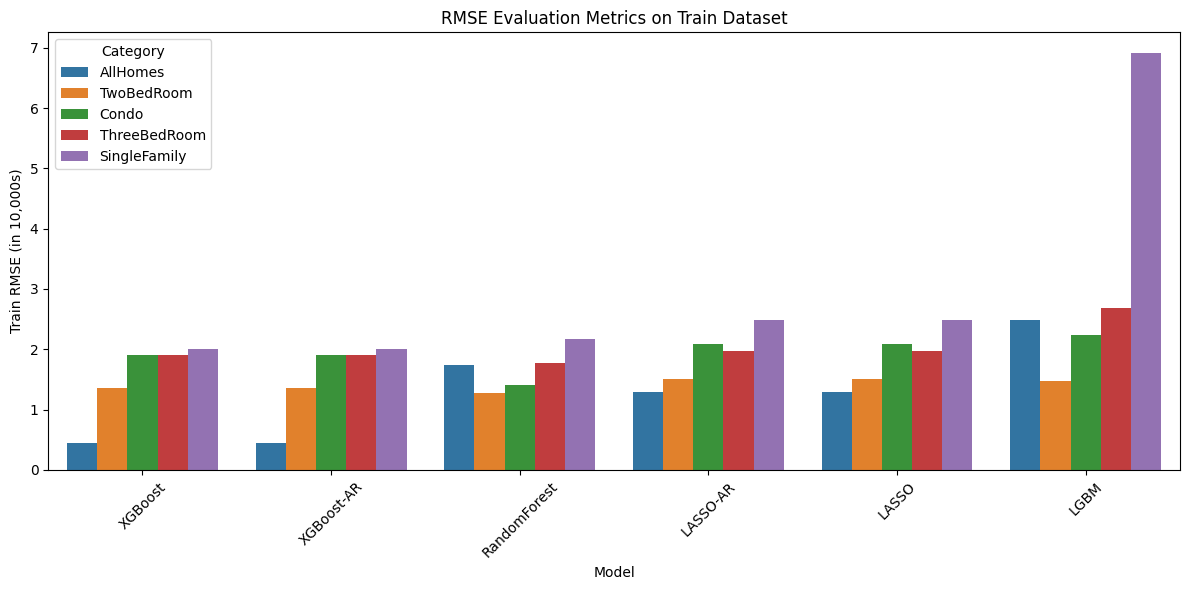

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Merge the results into one dataframe
# Merge the results into one dataframe
merged_results = pd.concat([xgb_results_df, xgb_ar_results_df,rf_results_df, lasso_ar_results_df, lgbm_results_df,lasso_results_df], 
                           keys=['XGBoost', 'XGBoost-AR', 'RandomForest', 'LASSO-AR', 'LGBM','LASSO'], 
                           names=['Model', 'Index']).reset_index()
# Sort the results by Train RMSE in ascending order
sorted_results = merged_results.sort_values(by='Train RMSE')

# Define a discrete color palette
palette = sns.color_palette("tab10", n_colors=sorted_results['Category'].nunique())

# Plot the results
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=sorted_results, x='Model', y='Train RMSE', hue='Category', palette=palette)

# Update Y-axis labels to show values in multiples of 10,000
plt.gca().set_yticklabels([int(label) // 10000 for label in plt.gca().get_yticks()])
plt.title('RMSE Evaluation Metrics on Train Dataset')
plt.xlabel('Model')
plt.ylabel('Train RMSE (in 10,000s)')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()


Plot the RMSE Results on all Models in ascending order of RMSE on Test Dataset.

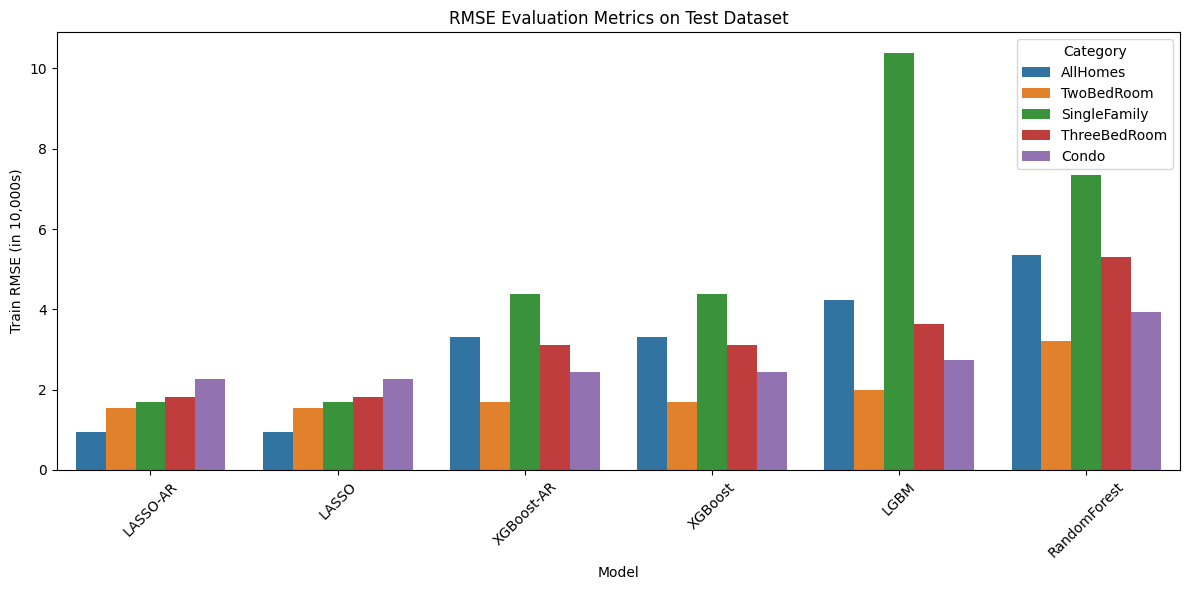

In [57]:
import seaborn as sns

import matplotlib.pyplot as plt

# Merge the results into one dataframe
merged_results = pd.concat([xgb_results_df, xgb_ar_results_df,rf_results_df, lasso_ar_results_df, lgbm_results_df,lasso_results_df], 
                           keys=['XGBoost', 'XGBoost-AR', 'RandomForest', 'LASSO-AR', 'LGBM','LASSO'], 
                           names=['Model', 'Index']).reset_index()

# Sort the results by Train RMSE in ascending order
sorted_results = merged_results.sort_values(by='Test RMSE')

# Define a discrete color palette
palette = sns.color_palette("tab10", n_colors=sorted_results['Category'].nunique())

# Plot the results
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=sorted_results, x='Model', y='Test RMSE', hue='Category', palette=palette)

# Update Y-axis labels to show values in multiples of 10,000
plt.gca().set_yticklabels([int(label) // 10000 for label in plt.gca().get_yticks()])
plt.title('RMSE Evaluation Metrics on Test Dataset')
plt.xlabel('Model')
plt.ylabel('Train RMSE (in 10,000s)')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

Across  all Categories and with RMSE on Train Datasets; XGBoost has best RMSE on Train dataset.
For Test Dataset ; LASSO - AR Model performed better with best RMSE followed by LASSO and then XGBoost-AR, XGBoost , LGBM and Rnadom Forest .
This might be due to overfitting in XGBOOST with Training Data. So we can conclude LASSO with Auto regressive model performed better in all models.